<a href="https://colab.research.google.com/github/talhaanwarch/PPG_mental_stress/blob/master/GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install deap

     |████████████████████████████████| 163kB 2.8MB/s 


In [0]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [0]:
url='https://raw.githubusercontent.com/talhaanwarch/PPG_mental_stress/master/data.csv'

In [0]:
data=pd.read_csv(url)

In [4]:
data.head()

,Mean RR*,STD RR (SDNN),Mean HR*,Min HR,RMSSD,NNxx,pNNxx,HRV triangular index,TINN,"Poincare plot, SD1","Poincare plot, SD2",FFT Power (ms2),FFT Power (log),AR Power (ms2),AR Power (log),FFT Power (ms2).1,FFT Power (log).1,AR Power (ms2).1,AR Power (log).1,Class
0,711.63,37.729,84.314,68.650,26.4880,166,9.464100,12.8100,187,9.0405,28.248,268.18,5.5917,289.26,5.6673,53.782,3.9849,56.074,4.0267,0
1,777.13,12.742,77.207,65.502,8.7235,1,0.062267,4.3668,70,6.1704,16.934,101.23,4.6174,101.64,4.6215,23.747,3.1674,22.940,3.1329,0
2,620.35,21.315,96.720,80.000,17.4290,30,1.684400,5.3036,194,7.9726,20.423,169.02,5.1300,181.95,5.2037,114.770,4.7429,167.440,5.1206,0
3,792.12,36.751,75.746,56.604,23.6630,113,7.266900,11.7880,200,16.7380,49.142,900.60,6.8031,862.01,6.7593,157.190,5.0574,156.600,5.0537,0
4,672.65,39.062,89.199,71.090,21.7000,100,5.546300,10.8670,239,15.3490,53.069,1115.30,7.0169,1111.80,7.0137,130.210,4.8692,134.590,4.9023,0


In [0]:
X=data.iloc[:,0:-1]
y=data.iloc[:,-1]

In [0]:
from deap import creator, base, tools, algorithms
import random
import numpy as np
from deap import tools
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

class FeatureSelectionGA:

    def __init__(self, model, x, y, cv_split=5, n_pop=15, n_gen=10):
      
        self.model = model
        self.n_features = x.shape[1]
        self.cv_split = cv_split
        self.x = x
        self.y = y
        self.n_pop = n_pop
        self.n_gen = n_gen
        print("The number of Features: {}".format(self.n_features))
        print("The Shape of Training Data is : {} and Target Data is : {}".format(self.x.shape, self.y.shape))

        individual = [1 for i in range(x.shape[1])]
        print("Accuracy For All the features: " + str(self.fitness_test(individual)) + "\n")

        # Applying Genetic Algorithm
        eg = self.evolutionary_algorithm()
        hof=eg[0]
        log=eg[1]
        plt.plot(log.select("gen"),log.select("avg"))
        plt.title('Support Vector Machine Classifier',fontsize=12)
        plt.xlabel('generation',fontsize=12)
        plt.ylabel('accuracy',fontsize=12)
        plt.savefig('SVM.png')
        #plt.imshow()
        accuracy, individual, header = self.bestIndividual(hof)
        print('Best Accuracy: \t' + str(accuracy[0]))
        print('Number of Features in Subset: \t' + str(individual.count(1)))
        print('Feature Subset: ' + str(header)+'\n')
        #print('\n\nKindly Create a New Classifier with the Above Feature Set')




    def fitness_test(self, individual):
        """
        The Function Analyses Provides the average Cross Val Score Using All the Features
        :param individual:
        :return: Average Cross Val Score
        """
        alpha=0.01 #ranges from 0 to 1
        if (individual.count(0) != len(individual)):
            # Fetched the Index of the Individual
            cols = [index for index in range(len(individual)) if individual[index] == 0]

            # Fetching Feature Subset
            X_parsed = self.x.drop(self.x.columns[cols], axis=1)
            X_subset = pd.get_dummies(X_parsed)

            # Applying the Classification Algorithm
            classifier = self.model
            cross_v=cross_val_score(classifier, X_subset, self.y, cv=self.cv_split)
            acc=((sum(cross_v) / float(len(cross_v))),0)
            #return acc            
            return (alpha*(1.0 - acc[0]) + (1.0 - alpha)*(1.0 - (X_subset.shape[1])/10),0)#10 is total feature
        else:
            return (0,)

    def evolutionary_algorithm(self):
        """
        Declaring Global Variables for DEAP
        :return:
        """
        # Creating the Individual Using DEAP
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        # Creating ToolBox For The DEAP Framework
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", random.randint, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, self.n_features) #initialization
        toolbox.register("population", tools.initRepeat, list, toolbox.individual) #initialization
        toolbox.register("evaluate", self.fitness_test) #fitness function
        toolbox.register("mate", tools.cxTwoPoint)#crossover
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) #mutation 
        toolbox.register("select", tools.selTournament, tournsize=5) #selection 

        # Initialize Parameters
        pop = toolbox.population(n=self.n_pop)
        hof = tools.HallOfFame(self.n_pop * self.n_gen)#  best individual that ever lived in the population during the evolution.
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean) #avg score from fitness function
        stats.register("min", np.min)  #min score from fitness function
        stats.register("max", np.max)  #max score from fitness function

        # Genetic Algorithm
        pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=self.n_gen, stats=stats, halloffame=hof,verbose=True)

        # Return Fall Of Home
        return hof,log

    def bestIndividual(self, hof):
        """
        Get the best individual
        """
        maxAccurcy = 0.0
        for individual in hof:
            if (individual.fitness.values[0] > maxAccurcy):
                maxAccurcy = individual.fitness.values[0]
                _individual = individual

        _individualHeader = [list(self.x)[i] for i in range(len(_individual)) if _individual[i] == 1]
        return _individual.fitness.values, _individual, _individualHeader

In [8]:
est = SVC()
score =  cross_val_score(est, X, y, cv=5)
print("Without GSA: {:.2f}".format(np.mean(score)))

Without GSA: 0.63


The number of Features: 19
The Shape of Training Data is : (62, 19) and Target Data is : (62,)
Accuracy For All the features: (-0.8872820512820512, 0)

gen	nevals	avg      	min      	max     
0  	15    	0.0631701	-0.392282	0.399731
1  	9     	0.241352 	0.00324359	0.498577
2  	6     	0.432599 	0.300538  	0.597731
3  	7     	0.518484 	0.399577  	0.597731
4  	8     	0.571388 	0.498731  	0.597731
5  	13    	0.597731 	0.597731  	0.597731
6  	7     	0.584529 	0.39941   	0.598026
7  	9     	0.591168 	0.49841   	0.598026
8  	8     	0.591367 	0.499026  	0.598026
9  	8     	0.558426 	0.202026  	0.598026
10 	11    	0.578226 	0.400026  	0.598026
11 	12    	0.597996 	0.499026  	0.697026
12 	10    	0.637545 	0.499026  	0.795564
13 	8     	0.703505 	0.598026  	0.796026
14 	10    	0.7364   	0.598026  	0.796026
15 	7     	0.775919 	0.696564  	0.796026
16 	9     	0.776029 	0.597564  	0.894846
17 	10    	0.822354 	0.697026  	0.894846
18 	10    	0.861831 	0.696385  	0.894846
19 	9     	0.835435 	0.696577 

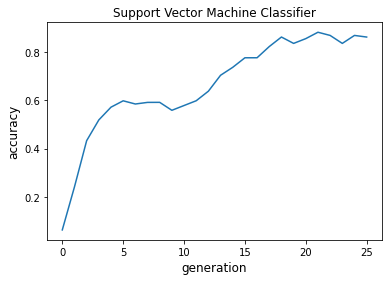

In [9]:
FeatureSelectionGA(est,X,y,n_gen=25)